# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import joblib

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pressburglabs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pressburglabs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pressburglabs/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
df = pd.read_csv('fake_job_postings.csv')
df = df.convert_dtypes()

In [4]:
print("Class Distribution:")
print(df['fraudulent'].value_counts(normalize=True))

Class Distribution:
fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: Float64


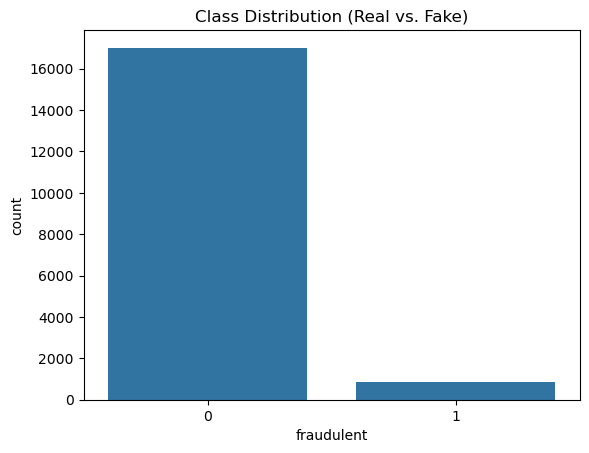

In [5]:
sns.countplot(x='fraudulent', data=df)
plt.title('Class Distribution (Real vs. Fake)')
plt.show()

In [6]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [7]:
print("\nFraudulent vs. Meta-Features:")
for col in ['telecommuting', 'has_company_logo', 'has_questions']:
    print(f"\n{col}:")
    print(pd.crosstab(df[col], df['fraudulent'], normalize='index'))


Fraudulent vs. Meta-Features:

telecommuting:
fraudulent            0         1
telecommuting                    
0              0.953135  0.046865
1              0.916558  0.083442

has_company_logo:
fraudulent               0         1
has_company_logo                    
0                 0.840710  0.159290
1                 0.980098  0.019902

has_questions:
fraudulent            0         1
has_questions                    
0              0.932218  0.067782
1              0.971565  0.028435


In [8]:
stop_words = set(stopwords.words('english'))
def get_top_words(text_series, n=10):
    words = []
    for text in text_series.dropna():
        tokens = word_tokenize(text.lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words])
    return Counter(words).most_common(n)

In [9]:
print("\nTop Words in Fraudulent Descriptions:")
print(get_top_words(df[df['fraudulent'] == 1]['description'], 10))
print("\nTop Words in Real Descriptions:")
print(get_top_words(df[df['fraudulent'] == 0]['description'], 10))


Top Words in Fraudulent Descriptions:
[('work', 962), ('amp', 695), ('team', 477), ('company', 477), ('position', 470), ('experience', 464), ('project', 438), ('customer', 438), ('business', 436), ('management', 429)]

Top Words in Real Descriptions:
[('team', 17162), ('work', 13409), ('business', 10038), ('new', 9384), ('experience', 9184), ('company', 9170), ('customer', 9132), ('sales', 8837), ('looking', 8307), ('development', 7705)]


# Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import numpy as np

In [11]:
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_cols:
    df[col] = df[col].fillna('')

In [12]:
df['combined_text'] = df[text_cols].agg(' '.join, axis=1)

In [13]:
cat_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = df[col].fillna('Unknown')
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    joblib.dump(le, f'label_encoder_{col}.pkl')

In [14]:
meta_features = ['telecommuting', 'has_company_logo', 'has_questions'] + cat_cols

In [15]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = tfidf.fit_transform(df['combined_text'])

In [16]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [17]:
X_meta = df[meta_features].values
X = np.hstack((X_text.toarray(), X_meta))

In [18]:
y = df['fraudulent'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [21]:
print("Original Train Class Distribution:", Counter(y_train))
print("Resampled Train Class Distribution:", Counter(y_train_res))

Original Train Class Distribution: Counter({0: 13611, 1: 693})
Resampled Train Class Distribution: Counter({0.0: 13611, 1.0: 13611})


# Train SVM Models

In [22]:
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import classification_report, confusion_matrix
import time

In [23]:
models = {
    'SVC_linear': SVC(kernel='linear', random_state=42),
    'LinearSVC': LinearSVC(random_state=42),
}

In [24]:
import joblib

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    model.fit(X_train_res, y_train_res)
    joblib.dump(model, name + '.pkl')
    y_pred = model.predict(X_test)

    print(f"\n{name} Results:")
    print(f"Training Time: {time.time() - start_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Training SVC_linear...

SVC_linear Results:
Training Time: 818.08 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3403
         1.0       0.85      0.86      0.85       173

    accuracy                           0.99      3576
   macro avg       0.92      0.92      0.92      3576
weighted avg       0.99      0.99      0.99      3576


Confusion Matrix:
[[3376   27]
 [  25  148]]

Training LinearSVC...

LinearSVC Results:
Training Time: 5.43 seconds

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3403
         1.0       0.82      0.84      0.83       173

    accuracy                           0.98      3576
   macro avg       0.91      0.92      0.91      3576
weighted avg       0.98      0.98      0.98      3576


Confusion Matrix:
[[3371   32]
 [  27  146]]
